<a href="https://colab.research.google.com/github/JayThibs/rome-experiments/blob/main/notebooks/causal_trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
# %%bash
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
# cd /content && rm -rf /content/rome
# git clone https://github.com/kmeng01/rome rome > install.log 2>&1

In [4]:
# !git clone https://github.com/kmeng01/rome

In [5]:
import os
os.chdir('rome')
!pip install -r /content/drive/MyDrive/rome/scripts/colab_reqs/rome.txt -q
!pip install --upgrade google-cloud-storage -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 311 kB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 58.2 MB/s 
     |████████████████████████████████| 120 kB 54.9 MB/s 
     |████████████████████████████████| 880 kB 43.2 MB/s 
     |████████████████████████████████| 115 kB 61.7 MB/s 
     |████████████████████████████████| 212 kB 53.2 MB/s 
     |████████████████████████████████| 106 kB 4.0 MB/s 
     |████████████████████████████████| 76 kB 4.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-translate 1.5.0 requires google-cloud-core<2.0dev,>=1.0.0, but you have google-cloud-core 2.3.2 which is incompatible.
google-cloud-firestore 1.7.0 requires google-cloud-core<2.0dev,>=1.0.3, but you have google-cloud-core 2.3.

In [1]:
IS_COLAB = False
try:
    import google.colab, torch, os
    IS_COLAB = True
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

# Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

In [2]:
%load_ext autoreload
%autoreload 2

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [3]:
import os, re, json
import torch, numpy
from transformers import AutoModelForCausalLM, AutoTokenizer
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import ModelAndTokenizer, layername, guess_subject, plot_trace_heatmap
from experiments.causal_trace import make_inputs, decode_tokens, find_token_range
from experiments.causal_trace import predict_token, predict_from_input
from dsets import KnownsDataset

Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [4]:
torch.set_grad_enabled(False)

model_name = r"EleutherAI/gpt-j-6B"

# Note that if you trace other models, you should set noise_level appropriately.
# (We use 0.03 for gpt-neox-20b and 0.025 for gpt-j-6b)
#model_name = r"EleutherAI/gpt-neox-20b"
#model_name = r"EleutherAI/gpt-j-6B"

torch_dtype = torch.float16 if '20b' in model_name else None

mt = ModelAndTokenizer(model_name, low_cpu_mem_usage=IS_COLAB, torch_dtype=torch_dtype)
predict_token(mt, ['Megan Rapinoe plays the sport of',
                   'The Space Needle is in the city of'
                  ], return_p=True)

([' soccer', ' Seattle'], tensor([0.6870, 0.9229], device='cuda:0'))

In [5]:
prompts = ['Megan Rapinoe plays the sport of']
device = 'cuda'
token_lists = [mt.tokenizer.encode(p) for p in prompts]
maxlen = max(len(t) for t in token_lists)
if "[PAD]" in mt.tokenizer.all_special_tokens:
    pad_id = mt.tokenizer.all_special_ids[mt.tokenizer.all_special_tokens.index("[PAD]")]
else:
    pad_id = 0
input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
inp = dict(
    input_ids=torch.tensor(input_ids).to(device),
    #    position_ids=torch.tensor(position_ids).to(device),
    attention_mask=torch.tensor(attention_mask).to(device),
)

## Tracing a single location

The core intervention in causal tracing is captured in this function:

`trace_with_patch` a single causal trace.

It enables running a batch of inferences with two interventions.

  1. Random noise can be added to corrupt the inputs of some of the batch.
  2. At any point, clean non-noised state can be copied over from an
     uncorrupted batch member to other batch members.
  
The convention used by this function is that the zeroth element of the
batch is the uncorrupted run, and the subsequent elements of the batch
are the corrupted runs.  The argument tokens_to_mix specifies an
be corrupted by adding Gaussian noise to the embedding for the batch
inputs other than the first element in the batch.  Alternately,
subsequent runs could be corrupted by simply providing different
input tokens via the passed input batch.

To ensure that corrupted behavior is representative, in practice, we
will actually run several (ten) corrupted runs in the same batch,
each with its own sample of noise.

Then when running, a specified set of hidden states will be uncorrupted
by restoring their values to the same vector that they had in the
zeroth uncorrupted run.  This set of hidden states is listed in
states_to_patch, by listing [(token_index, layername), ...] pairs.
To trace the effect of just a single state, this can be just a single
token/layer pair.  To trace the effect of restoring a set of states,
any number of token indices and layers can be listed.

Note that this function is also in experiments.causal_trace; the code
is shown here to show the logic.

In [6]:
def trace_with_patch(
    model,            # The model
    inp,              # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,        # Answer probabilities to collect
    tokens_to_mix,    # Range of tokens to corrupt (begin, end)
    noise=0.1,        # Level of noise to add
    trace_layers=None # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, 'embed')
    
    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] +
            list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2)
        return probs, all_traced

    return probs

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [39]:
test = (0, 100)
new = (50, test[-1])
new

(50, 100)

In [40]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None, remove_context=0
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    print(f"Calculating hidden flow for {subject} in {prompt}")
    print(remove_context)
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    # e_range = (remove_context, e_range[-1])
    low_score = trace_with_patch(mt.model, inp, [], answer_t, e_range,
            noise=noise).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise, remove_context=remove_context
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
            remove_context=remove_context
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )

def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1, remove_context=0):
    ntoks = inp["input_ids"].shape[1]
    table = []
    print('trace_important_states')
    print('remove_context', remove_context)
    for tnum in range(remove_context, ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1, remove_context=0
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    print('trace_important_window')
    print('remove_context', remove_context)
    for tnum in range(remove_context, ntoks):
        print("tnum:", tnum)
        row = []
        for layer in range(0, num_layers):
            print("layer:", layer)
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)



## Plotting the results

The `plot_trace_heatmap` function draws the data on a heatmap.  That function is not shown here; it is in `experiments.causal_trace`.


In [44]:
def plot_hidden_flow(
    mt, prompt, subject=None, include_plots=True, samples=10, noise=0.1, window=10, 
    kind=None, modelname=None, savepdf=None, remove_context=0
):
    print('plot_hidden_flow')
    print('savepdf:', savepdf)
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind, remove_context=remove_context
    )
    if include_plots:
        print('plot_trace_heatmap')
        print('remove_context:', remove_context)
        plot_trace_heatmap(result, savepdf, modelname=modelname, remove_context=remove_context)
    return result
    
def plot_flows(mt, prompt, subject=None, plot_num=0, noise=0.1, modelname=None, 
               plots=[None, "mlp", "attn"], include_plots=True, savepdf=None, 
               plotsubset=None, remove_context=0, results_dict={}):
    i = plot_num
    # print(savepdf)
    # print('wtf')
    for kind in plots:
        if kind is None:
            j = "fully_restored"
        else:
            j = kind
        if savepdf:
            filename = j + "_" + savepdf
            filepath = plotsubset + filename
        print("filepath:", filepath)
        if results_dict.get(filename) is None:
            results_dict[filename] = {}
        print('remove_context:', remove_context)
        result = plot_hidden_flow(mt, prompt, subject, include_plots, modelname=modelname,
                                  savepdf=filepath, noise=noise, kind=kind, remove_context=remove_context)
        results_dict[filename][j] = {}
        results_dict[filename][j] = result

    return results_dict

The following prompt can be changed to any factual statement to trace.

In [19]:
prompt = """Q: Take the last letters of the words in "Elon Musk" and concatenate them.
A: The last letter of "Elon" is "n". The last letter of "Musk" is "k". Concatenating them is "nk". The answer is nk.
Q: Take the last letters of the words in "Larry Page" and concatenate them.
A: The last letter of "Larry" is "y". The last letter of "Page" is "e". Concatenating them is "ye". The answer is ye.
Q: Take the last letters of the words in "Sergey Brin" and concatenate them.
A: The last letter of "Sergey" is "y". The last letter of "Brin" is "n". Concatenating them is "yn". The answer is
yn.
Q: Take the last letters of the words in "Bill Gates" and concatenate them.
A: The last letter of "Bill" is "l". The last letter of "Gates" is "s". Concatenating them is "ls". The answer is"""

prompt = """Shree Pundalik, created in the country of his birth,"""
prompt = """This silent film produced by Dadasaheb Torne was released in 18 May 1912 and was the first feature film of this country. And that country was"""
# prompt = "The famous tower people go visit in France is called the"
# prompt = "The tower named after the engineer Gustave Eiffel is called the"
# prompt = "The famous tower located located in Paris is called the"
# prompt = "The Eiffel Tower is located in"
# prompt = "The famous tower that was built to celebrate the 100th year anniversary of the French Revolution is located in the city of"

subject = """The last letter of "Bill" is "l". The last letter of "Gates" is "s". Concatenating them is "ls"."""

# predict_token(mt, [prompt])
device = 'cuda'
input = mt.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
gen_outputs = mt.model.generate(
        input,
        do_sample=True,
        early_stopping=True,
        max_length=40,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=mt.tokenizer.eos_token_id,
        temperature=0.05
    )
mt.tokenizer.decode(gen_outputs.sequences[0])


'This silent film produced by Dadasaheb Torne was released in 18 May 1912 and was the first feature film of this country. And that country was India.\n\nThe film was made by'

In [28]:
prompts = ["""Shree Pundalik, created in the country of his birth,""",
           """This silent film produced by Dadasaheb Torne was released in 18 May 1912 and was the first feature film of this country. And that country was""",
           "The famous tower people go visit in France is called the",
           "The tower named after the engineer Gustave Eiffel is called the",
           "The famous tower located located in Paris is called the",
           "The Eiffel Tower is located in",
           "The famous tower that was built to celebrate the 100th year anniversary of the French Revolution is located in the city of",
           "The mother tongue of Danielle Darrieux is",
           """The mother tongue of the lead actress from the film 'The Earrings of Madame de' is""",
           "Iron Man is affiliated with the",
           "The Marvel hero in the iron suit is affiliated with the",
           "In Singapore, the language spoken is",
           "The country where Lee Hsien Loong is the prime minister mainly speaks in",
           ]
subjects = ["Shree Pundalik",
            "silent film produced by Dadasaheb Torne was released in 18 May 1912",
            "famous tower people go visit in France",
            "tower named after the engineer Gustave Eiffel",
            "famous tower located located in Paris",
            "Eiffel Tower",
            "famous tower that was built to celebrate the 100th year anniversary of the French Revolution",
            "Danielle Darrieux",
            "lead actress from the film 'The Earrings of Madame de'",
            "Iron Man",
            "Marvel hero in the iron suit",
            "Singapore",
            "country where Lee Hsien Loong is the prime minister",
            ]

# prompts = ["In the country of Singapore, the main language that is spoken is"]
# subjects = ["Singapore"]

# prompts = ["Iron Man is with"]
# subjects = ["Iron"]

# prompts = ["""Question: Are more people today related to Genghis Khan than Julius Caesar?
# Facts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan. 
# Answer (True or False): True
# """]

# subjects = []

In [21]:
import json
os.chdir("..")
with open("./data/good_sqa_gpt2.json") as f:
    good_sqa = json.load(f)

good_sqa['0']

FileNotFoundError: [Errno 2] No such file or directory: './data/good_sqa_gpt2.json'

In [34]:
good_sqa['0']

{'qid': '7419826e4373eb1e83ff',
 'term': 'Grey seal',
 'description': 'species of seal',
 'question': 'Would a dog respond to bell before Grey seal?',
 'answer': True,
 'facts': ['Grey seals have no ear flaps and their ears canals are filled with wax.',
  'Grey seals hear better underwater when their ears open like a valve.',
  'Dogs have sensitive ears that can hear as far as a quarter of a mile away.'],
 'decomposition': ["How sensitive is a grey seal's hearing on land?",
  "How sensitive is a dog's hearing on land?",
  'Is #2 better than #1?'],
 'evidence': [[[['Pinniped-24']],
   [['Hearing range-11', 'Hertz-5']],
   ['operation']],
  [[['Grey seal-1'], 'no_evidence'],
   [['Dog-54'], 'no_evidence'],
   ['no_evidence', 'operation']],
  [[['Grey seal-1'], 'no_evidence'], [['Dog anatomy-114']], ['operation']]],
 'first_generated_token': 'True',
 'gpt2_main_completion': ' True\nQuestion: What is the longest distance a dog can travel in one day?\nFacts: A dog can travel up to 100 miles

In [45]:
results_dict = {}

In [46]:
from tqdm import tqdm
# plotsubset = "./data/curated_ct_prompts/"
# os.makedirs(plotsubset, exist_ok=True)
# for prompt, subject in zip(prompts, subjects):
#     # try:
#     # tokens = mt.tokenizer(prompt, add_special_tokens=False, 
#     #                     return_tensors="pt").input_ids.to(device)
#     # tokens = tokens[0][:70]
#     # prompt = mt.tokenizer.decode(tokens)
#     # subject = tokens[68:70]
#     # subject = mt.tokenizer.decode(subject)
#     # print(prompt)
#     # print(subject)
#     pdf_name = subject.replace(' ', '_').replace(".", "_")
#     pdf_name = re.sub('[^0-9a-zA-Z]', '_', pdf_name)[:40]
#     plot_flows(mt, prompt, subject=subject, savepdf=pdf_name,
#     plotsubset=plotsubset, remove_context=0)
#     # except:
#     #     pass

# for sqa_i in good_sqa:
#     try:
#         prompt = sqa_i['ct_prompt']
#         subject = sqa_i['ct_subject']
#         plot_flows(mt, prompt, subject=subject, )
#     except:
#         pass

i = 0
plotsubset = "./data/good_cot_sqa/"
os.makedirs(plotsubset, exist_ok=True)
# for knowledge in knowns[0:2]:
for i in tqdm(good_sqa):
    # try:
    i = str(i)
    subject = good_sqa[i]['ct_subject']
    print('subject:', subject)
    prompt = good_sqa[i]['ct_prompt']
    print('prompt:', prompt)
    # tokens = mt.tokenizer(prompt, add_special_tokens=False, 
    #                         return_tensors="pt").input_ids.to(device)
    # tokens = tokens[0][:70]
    # prompt = mt.tokenizer.decode(tokens)
    # print(prompt)
    # break
    # subject = tokens[67:]
    # subject = mt.tokenizer.decode(subject)
    token_prob = str(round(float(good_sqa[i]['token_probs'][0][1]), 3)).replace(".", "p")
    pdf_name = token_prob + "_" + subject.replace(' ', '_').replace(".", "_")
    pdf_name = re.sub('[^0-9a-zA-Z]', '_', pdf_name)[:40]
    print(pdf_name)
    results_dict = plot_flows(mt, prompt, subject, plot_num=i,
                            include_plots=True, savepdf=pdf_name, 
                            plotsubset=plotsubset, results_dict=results_dict,
                            remove_context=67)
#     # except:
#     #     pass

  0%|          | 0/1070 [00:00<?, ?it/s]

subject: Grey seals have no ear flaps and their ears canals are filled with wax. Grey seals hear better underwater when their ears open like a valve. Dogs have sensitive ears that can hear as far as a quarter of a mile away.
prompt: Question: Are more people today related to Genghis Khan than Julius Caesar?
Facts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan.
Answer (True or False): True
Question: Would a dog respond to bell before Grey seal?
Facts: Grey seals have no ear flaps and their ears canals are filled with wax. Grey seals hear better underwater when their ears open like a valve. Dogs have sensitive ears that can hear as far as a quarter of a mile away.
Answer (True or False):
1p0_Grey_seals_have_no_ear_flaps_and_the
filepath: ./data/good_cot_sqa/fully_restored_1p0_Grey_seals_have_no_ear_flaps_and_the
remove_context: 67
plot_hidden_flow
savepdf: 

  0%|          | 0/1070 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [44]:
subject = good_sqa[i]['ct_subject']
prompt = good_sqa[i]['ct_prompt']
subject

'Grey seals have no ear flaps and their ears canals are filled with wax. Grey seals hear better underwater when their ears open like a valve. Dogs have sensitive ears that can hear as far as a quarter of a mile away.'

In [124]:
tokens = mt.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
tokens = tokens[0][:70]
text = mt.tokenizer.decode(tokens)
text

'Question: Are more people today related to Genghis Khan than Julius Caesar?\nFacts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan.\nAnswer (True or False): True\nQuestion: Is'

Here we trace a few more factual statements from a file of test cases.

In [49]:
knowns = KnownsDataset(DATA_DIR)

# for knowledge in knowns[0:1]:
#     plot_flows(mt, knowledge['prompt'], knowledge['subject'])

Loaded dataset with 1209 elements


Now, let's try to find out some interesting stuff using Causal Tracing. Are there some patterns we can recognize?

Let's run through the entire Known dataset and then have a look at some commonalities between the subjects that have more effect in the later layers than the earlier layers.

In [37]:
knowns[0]

{'known_id': 0,
 'subject': 'Vinson Massif',
 'attribute': 'Antarctica',
 'template': '{} is located in the continent',
 'prediction': ' of Antarctica. It is the largest of the three',
 'prompt': 'Vinson Massif is located in the continent of',
 'relation_id': 'P30'}

In [38]:
import json

good_cf_filename = "/content/drive/MyDrive/rome/data/good_counterfact_gpt2.json"
with open(good_cf_filename, 'r') as f:
    good_cfs = json.loads(f.read())

bad_cf_filename = "/content/drive/MyDrive/rome/data/bad_counterfacts_gpt2.json"
with open(bad_cf_filename) as f:
    bad_cfs = json.loads(f.read())

In [39]:
float(bad_cfs['0']['token_probs'][0][1])

0.9990845

In [40]:
uncertain_count = 0
certain_count = 0
bad_uncertain_cfs = {}
bad_certain_cfs = {}
for i in list(bad_cfs.keys()):
    first_gen_token_prob = float(bad_cfs[i]['token_probs'][0][1])
    if first_gen_token_prob < 0.2:
        bad_uncertain_cfs[uncertain_count] = bad_cfs[i]
        uncertain_count += 1
    elif first_gen_token_prob > 0.999:
        bad_certain_cfs[certain_count] = bad_cfs[i]
        certain_count += 1

print(uncertain_count)
print(certain_count)

486
9883


In [41]:
uncertain_count = 0
certain_count = 0
good_uncertain_cfs = {}
good_certain_cfs = {}
for i in list(good_cfs.keys()):
    first_gen_token_prob = float(good_cfs[i]['token_probs'][0][1])
    if first_gen_token_prob < 0.2:
        good_uncertain_cfs[uncertain_count] = good_cfs[i]
        uncertain_count += 1
    elif first_gen_token_prob > 0.999:
        good_certain_cfs[certain_count] = good_cfs[i]
        certain_count += 1

print(uncertain_count)
print(certain_count)

77
2677


In [19]:
savepdf = "/content/drive/MyDrive/rome/data/image.png"
if savepdf:
    print(os.path.dirname(savepdf))

/content/drive/MyDrive/rome/data


In [43]:
# import shutil
# shutil.rmtree('/content/rome/data/bad_uncertains')

In [44]:
results_dict = {}

In [45]:
from tqdm import tqdm
i = 0
plotsubset = "/content/drive/MyDrive/rome/data/bad_uncertains/"
os.makedirs(plotsubset, exist_ok=True)
# for knowledge in knowns[0:2]:
for i in tqdm(bad_uncertain_cfs):
    try:
        subject = bad_uncertain_cfs[i]['requested_rewrite']['subject']
        prompt = bad_uncertain_cfs[i]['requested_rewrite']['prompt'].replace("{}", subject)
        print(prompt)
        token_prob = str(round(float(bad_uncertain_cfs[i]['token_probs'][0][1]), 3)).replace(".", "p")
        pdf_name = token_prob + "_" + prompt.replace(' ', '_').replace(".", "_")
        pdf_name = re.sub('[^0-9a-zA-Z]', '_', pdf_name)
        print(pdf_name)
        print(token_prob)
        results_dict = plot_flows(mt, prompt, subject, plot_num=i,
                                include_plots=True, plots=["mlp"], 
                                savepdf=pdf_name, plotsubset=plotsubset, results_dict=results_dict)
    except:
        pass
    i += 1
    if i > 100:
        break

  0%|          | 0/486 [00:00<?, ?it/s]

Toko Yasuda, the
0p137_Toko_Yasuda__the
0p137


  0%|          | 1/486 [00:19<2:40:11, 19.82s/it]

The Loner was released on
0p107_The_Loner_was_released_on
0p107


  0%|          | 2/486 [00:39<2:38:46, 19.68s/it]

Charles IV of Spain's life ended in
0p019_Charles_IV_of_Spain_s_life_ended_in
0p019


  1%|          | 3/486 [01:06<3:04:24, 22.91s/it]

Flotation Toy Warning, founded in
0p084_Flotation_Toy_Warning__founded_in
0p084


  1%|          | 4/486 [01:29<3:04:29, 22.97s/it]

Luana Walters's profession is an
0p177_Luana_Walters_s_profession_is_an
0p177


  1%|          | 5/486 [01:52<3:03:39, 22.91s/it]

Pinhas Hirschprung passed away in
0p006_Pinhas_Hirschprung_passed_away_in
0p006


  1%|          | 6/486 [02:27<3:38:09, 27.27s/it]

Onufri works in the field of
0p051_Onufri_works_in_the_field_of
0p051


  1%|▏         | 7/486 [02:54<3:35:04, 26.94s/it]

The occupation of Sepala Attygalle is
0p017_The_occupation_of_Sepala_Attygalle_is
0p017


  2%|▏         | 8/486 [03:34<4:08:26, 31.19s/it]

Murphy Brown was originally aired on
0p157_Murphy_Brown_was_originally_aired_on
0p157


  2%|▏         | 9/486 [03:57<3:46:57, 28.55s/it]

Delchev Ridge is located in the continent
0p173_Delchev_Ridge_is_located_in_the_continent
0p173


  2%|▏         | 10/486 [04:23<3:40:55, 27.85s/it]

The language of Planet of the Apes was
0p008_The_language_of_Planet_of_the_Apes_was
0p008


  2%|▏         | 11/486 [04:58<3:58:54, 30.18s/it]

Novelas ejemplares was developed in
0p077_Novelas_ejemplares_was_developed_in
0p077


  2%|▏         | 12/486 [05:39<4:22:48, 33.27s/it]

The language of Rasayana is
0p041_The_language_of_Rasayana_is
0p041


  3%|▎         | 13/486 [06:01<3:57:21, 30.11s/it]

Joe Darensbourg is known for performing
0p117_Joe_Darensbourg_is_known_for_performing
0p117


  3%|▎         | 14/486 [06:37<4:09:32, 31.72s/it]

Matt Lavelle is known for performing
0p11_Matt_Lavelle_is_known_for_performing
0p11


  3%|▎         | 15/486 [07:03<3:56:38, 30.15s/it]

Cape Legoupil is located in the continent
0p049_Cape_Legoupil_is_located_in_the_continent
0p049


  3%|▎         | 16/486 [07:43<4:18:49, 33.04s/it]

Carol & Company was originally aired on
0p087_Carol___Company_was_originally_aired_on
0p087


  3%|▎         | 17/486 [08:10<4:02:56, 31.08s/it]

Neko Entertainment was formed in
0p049_Neko_Entertainment_was_formed_in
0p049


  4%|▎         | 18/486 [08:33<3:43:26, 28.65s/it]

The mother tongue of Toine Manders is
0p132_The_mother_tongue_of_Toine_Manders_is
0p132


  4%|▍         | 19/486 [09:08<3:58:15, 30.61s/it]

Heyday Films, founded in
0p043_Heyday_Films__founded_in
0p043


  4%|▍         | 20/486 [09:27<3:31:30, 27.23s/it]

Barnstable (village), Massachusetts, in
0p068_Barnstable__village___Massachusetts__in
0p068


  4%|▍         | 21/486 [10:03<3:51:41, 29.90s/it]

Robert Raymond passed away in
0p134_Robert_Raymond_passed_away_in
0p134


  5%|▍         | 22/486 [10:15<3:07:46, 24.28s/it]

In Kingdom of Tavolara, an official language is
0p1_In_Kingdom_of_Tavolara__an_official_language_is
0p1


  5%|▍         | 23/486 [10:59<3:54:08, 30.34s/it]

Manuel Ruiz Sosa, the
0p158_Manuel_Ruiz_Sosa__the
0p158


  5%|▍         | 24/486 [11:26<3:45:54, 29.34s/it]

The location of Radical War is
0p002_The_location_of_Radical_War_is
0p002


  5%|▌         | 25/486 [11:45<3:22:02, 26.30s/it]

The language of The Harvest Month was
0p111_The_language_of_The_Harvest_Month_was
0p111


  5%|▌         | 26/486 [12:08<3:13:25, 25.23s/it]

In Biasca, the language spoken is
0p003_In_Biasca__the_language_spoken_is
0p003


  6%|▌         | 27/486 [12:34<3:14:47, 25.46s/it]

James Rennell passed away in
0p154_James_Rennell_passed_away_in
0p154


  6%|▌         | 28/486 [12:57<3:08:36, 24.71s/it]

The native language of Francis Jammes is
0p01_The_native_language_of_Francis_Jammes_is
0p01


  6%|▌         | 29/486 [13:32<3:32:10, 27.86s/it]

Walker Digital was formed in
0p01_Walker_Digital_was_formed_in
0p01


  6%|▌         | 30/486 [13:43<2:53:45, 22.86s/it]

Cadillac Northstar LMP is developed by
0p062_Cadillac_Northstar_LMP_is_developed_by
0p062


  6%|▋         | 31/486 [14:24<3:33:08, 28.11s/it]

Kiev-Sviatoshyn Raion's capital city is
0p082_Kiev_Sviatoshyn_Raion_s_capital_city_is
0p082


  7%|▋         | 32/486 [15:46<5:36:35, 44.48s/it]

William Michael Rooke performs
0p02_William_Michael_Rooke_performs
0p02


  7%|▋         | 33/486 [15:58<4:21:13, 34.60s/it]

Jayakanthan speaks
0p033_Jayakanthan_speaks
0p033


  7%|▋         | 34/486 [16:09<3:28:30, 27.68s/it]

About Anglia, created in
0p023_About_Anglia__created_in
0p023


  7%|▋         | 35/486 [16:29<3:09:21, 25.19s/it]

James Morris Blaut works in the area of
0p06_James_Morris_Blaut_works_in_the_area_of
0p06


  7%|▋         | 36/486 [17:04<3:31:27, 28.19s/it]

Gabriel Heinze plays in the position of
0p14_Gabriel_Heinze_plays_in_the_position_of
0p14


  8%|▊         | 37/486 [17:39<3:46:41, 30.29s/it]

Jean Titelouze's occupation is
0p121_Jean_Titelouze_s_occupation_is
0p121


  8%|▊         | 38/486 [18:06<3:38:15, 29.23s/it]

Crossing Lines premieres on
0p028_Crossing_Lines_premieres_on
0p028


  8%|▊         | 39/486 [18:25<3:15:44, 26.27s/it]

The profession of Charles FitzGerald, 1st Baron Lecale is
0p141_The_profession_of_Charles_FitzGerald__1st_Baron_Lecale_is
0p141


  8%|▊         | 40/486 [19:58<5:43:18, 46.19s/it]

Agilbert, who has the position of
0p191_Agilbert__who_has_the_position_of
0p191


  8%|▊         | 41/486 [20:33<5:17:29, 42.81s/it]

Jim Magilton plays in the position of
0p015_Jim_Magilton_plays_in_the_position_of
0p015


  9%|▊         | 42/486 [20:59<4:40:03, 37.85s/it]

The domain of work of Nicole-Reine Lepaute is
0p147_The_domain_of_work_of_Nicole_Reine_Lepaute_is
0p147


  9%|▉         | 43/486 [22:14<6:01:12, 48.92s/it]

Snowbeast was released on
0p124_Snowbeast_was_released_on
0p124


  9%|▉         | 44/486 [22:33<4:55:07, 40.06s/it]

Joe Magrane, the
0p106_Joe_Magrane__the
0p106


  9%|▉         | 45/486 [22:45<3:51:15, 31.46s/it]

The headquarter of Samsung is in
0p137_The_headquarter_of_Samsung_is_in
0p137


  9%|▉         | 46/486 [23:07<3:30:38, 28.72s/it]

Selfish Cunt was formed in
0p159_Selfish_Cunt_was_formed_in
0p159


 10%|▉         | 47/486 [23:30<3:17:32, 27.00s/it]

Nathan Appleton worked in the city of
0p166_Nathan_Appleton_worked_in_the_city_of
0p166


 10%|▉         | 48/486 [24:05<3:35:01, 29.46s/it]

Vega4 that was founded in
0p078_Vega4_that_was_founded_in
0p078


 10%|█         | 49/486 [24:28<3:19:53, 27.44s/it]

Joan Dickson was born in
0p152_Joan_Dickson_was_born_in
0p152


 10%|█         | 50/486 [24:51<3:09:38, 26.10s/it]

Darol Anger, the
0p005_Darol_Anger__the
0p005


 10%|█         | 51/486 [25:02<2:37:11, 21.68s/it]

Carpentras, in
0p05_Carpentras__in
0p05


 11%|█         | 52/486 [25:22<2:32:13, 21.05s/it]

Betsson, founded in
0p125_Betsson__founded_in
0p125


 11%|█         | 53/486 [25:33<2:10:36, 18.10s/it]

Thomas Vose Daily holds the position of
0p008_Thomas_Vose_Daily_holds_the_position_of
0p008


 11%|█         | 54/486 [26:00<2:28:26, 20.62s/it]

Alabama Shakes was founded in
0p005_Alabama_Shakes_was_founded_in
0p005


 11%|█▏        | 55/486 [26:19<2:25:29, 20.25s/it]

Friday Night Videos was released on
0p085_Friday_Night_Videos_was_released_on
0p085


 12%|█▏        | 56/486 [26:39<2:24:11, 20.12s/it]

MacPaint was created by
0p063_MacPaint_was_created_by
0p063


 12%|█▏        | 57/486 [26:58<2:22:13, 19.89s/it]

The genre played by Hugo Weisgall is
0p023_The_genre_played_by_Hugo_Weisgall_is
0p023


 12%|█▏        | 58/486 [27:33<2:54:38, 24.48s/it]

Second Verdict was released on
0p102_Second_Verdict_was_released_on
0p102


 12%|█▏        | 59/486 [27:53<2:43:23, 22.96s/it]

myGRAIN was founded in
0p105_myGRAIN_was_founded_in
0p105


 12%|█▏        | 60/486 [28:16<2:42:55, 22.95s/it]

Hjalmar Branting passed away in
0p035_Hjalmar_Branting_passed_away_in
0p035


 13%|█▎        | 61/486 [28:51<3:09:40, 26.78s/it]

The language of Van der Valk was
0p197_The_language_of_Van_der_Valk_was
0p197


 13%|█▎        | 62/486 [29:18<3:08:39, 26.70s/it]

The twin city of Chicago is
0p182_The_twin_city_of_Chicago_is
0p182


 13%|█▎        | 63/486 [29:37<2:52:00, 24.40s/it]

What does Dhoom 3 play? They play
0p159_What_does_Dhoom_3_play__They_play
0p159


 13%|█▎        | 64/486 [30:12<3:13:46, 27.55s/it]

Marie Versini's occupation is
0p027_Marie_Versini_s_occupation_is
0p027


 13%|█▎        | 65/486 [30:31<2:56:10, 25.11s/it]

Rampart Ridge belongs to the continent of
0p034_Rampart_Ridge_belongs_to_the_continent_of
0p034


 14%|█▎        | 66/486 [31:06<3:16:53, 28.13s/it]

Iraq Football Association is a part of the
0p169_Iraq_Football_Association_is_a_part_of_the
0p169


 14%|█▍        | 67/486 [31:33<3:12:32, 27.57s/it]

The language used by Salvatore Accardo is
0p184_The_language_used_by_Salvatore_Accardo_is
0p184


 14%|█▍        | 68/486 [32:12<3:37:34, 31.23s/it]

The domain of work of Svante August Arrhenius is
0p017_The_domain_of_work_of_Svante_August_Arrhenius_is
0p017


 14%|█▍        | 69/486 [33:34<5:22:40, 46.43s/it]

Yangtze is in
0p003_Yangtze_is_in
0p003


 14%|█▍        | 70/486 [33:46<4:09:01, 35.92s/it]

The twin city of Karachi is
0p179_The_twin_city_of_Karachi_is
0p179


 15%|█▍        | 71/486 [34:05<3:33:22, 30.85s/it]

The profession of Jill Hyem is
0p004_The_profession_of_Jill_Hyem_is
0p004


 15%|█▍        | 72/486 [34:27<3:16:04, 28.42s/it]

Halle Berry's profession is a
0p009_Halle_Berry_s_profession_is_a
0p009


 15%|█▌        | 73/486 [34:50<3:03:52, 26.71s/it]

Odbert Island is a part of the continent of
0p014_Odbert_Island_is_a_part_of_the_continent_of
0p014


 15%|█▌        | 74/486 [35:34<3:39:21, 31.95s/it]

Wohlthat Mountains is a part of the continent of
0p052_Wohlthat_Mountains_is_a_part_of_the_continent_of
0p052


 15%|█▌        | 75/486 [36:19<4:03:55, 35.61s/it]

The mother tongue of Yuliya Snigir is
0p054_The_mother_tongue_of_Yuliya_Snigir_is
0p054


 16%|█▌        | 76/486 [37:03<4:22:08, 38.36s/it]

MMA Live premieres on
0p011_MMA_Live_premieres_on
0p011


 16%|█▌        | 77/486 [37:23<3:42:51, 32.69s/it]

Don Lusher performs
0p134_Don_Lusher_performs
0p134


 16%|█▌        | 78/486 [37:32<2:54:00, 25.59s/it]

Semyon Vorontsov is originally from
0p121_Semyon_Vorontsov_is_originally_from
0p121


 16%|█▋        | 79/486 [38:08<3:14:12, 28.63s/it]

Mercer Ellington plays
0p044_Mercer_Ellington_plays
0p044


 16%|█▋        | 80/486 [38:27<2:55:44, 25.97s/it]

Dodge Challenger, developed by
0p145_Dodge_Challenger__developed_by
0p145


 17%|█▋        | 81/486 [38:47<2:42:00, 24.00s/it]

Urban Outfitters was formed in
0p004_Urban_Outfitters_was_formed_in
0p004


 17%|█▋        | 82/486 [39:10<2:39:30, 23.69s/it]

selenium, which is named for
0p144_selenium__which_is_named_for
0p144


 17%|█▋        | 83/486 [39:32<2:36:44, 23.34s/it]

The language used by Giovanni Bertati is
0p014_The_language_used_by_Giovanni_Bertati_is
0p014


 17%|█▋        | 84/486 [39:58<2:42:13, 24.21s/it]

Frank Markham worked in the city of
0p107_Frank_Markham_worked_in_the_city_of
0p107


 17%|█▋        | 85/486 [40:25<2:45:52, 24.82s/it]

Flavio Zanonato, who has the position of
0p061_Flavio_Zanonato__who_has_the_position_of
0p061


 18%|█▊        | 86/486 [41:33<4:11:38, 37.75s/it]

The Banana Splits premieres on
0p185_The_Banana_Splits_premieres_on
0p185


 18%|█▊        | 87/486 [41:56<3:41:29, 33.31s/it]

Doriva, who plays the position
0p051_Doriva__who_plays_the_position
0p051


 18%|█▊        | 88/486 [42:22<3:26:53, 31.19s/it]

The original language of Yalkut Yosef is
0p094_The_original_language_of_Yalkut_Yosef_is
0p094


 18%|█▊        | 89/486 [43:01<3:43:20, 33.75s/it]

Bobby Hull is a professional
0p06_Bobby_Hull_is_a_professional
0p06


 19%|█▊        | 90/486 [43:21<3:14:24, 29.46s/it]

The official language of Tavannes is
0p115_The_official_language_of_Tavannes_is
0p115


 19%|█▊        | 91/486 [43:47<3:07:36, 28.50s/it]

Toronto is a twin city of
0p031_Toronto_is_a_twin_city_of
0p031


 19%|█▉        | 92/486 [44:06<2:48:27, 25.65s/it]

Anton Zeilinger works in the field of
0p196_Anton_Zeilinger_works_in_the_field_of
0p196


 19%|█▉        | 93/486 [44:46<3:15:47, 29.89s/it]

Real People premieres on
0p19_Real_People_premieres_on
0p19


 19%|█▉        | 94/486 [44:57<2:38:48, 24.31s/it]

Ken O'Brien plays in the position of
0p164_Ken_O_Brien_plays_in_the_position_of
0p164


 20%|█▉        | 95/486 [45:32<2:59:38, 27.57s/it]

Noel Mewton-Wood, performing on the
0p09_Noel_Mewton_Wood__performing_on_the
0p09


 20%|█▉        | 96/486 [46:12<3:23:33, 31.32s/it]

In Janakkala, the language spoken is
0p073_In_Janakkala__the_language_spoken_is
0p073


 20%|██        | 98/486 [46:52<2:33:06, 23.68s/it]

Vladimír Růžička, the
0p017_Vladim_r_R__i_ka__the
0p017
Skylar Grey, performing on the
0p077_Skylar_Grey__performing_on_the
0p077


 20%|██        | 99/486 [47:15<2:30:54, 23.40s/it]

The official religion of Amānullāh Khān is
0p121_The_official_religion_of_Am_null_h_Kh_n_is
0p121


 21%|██        | 100/486 [48:30<4:10:23, 38.92s/it]

Mark Malone plays as
0p188_Mark_Malone_plays_as
0p188


 21%|██        | 100/486 [48:39<3:07:48, 29.19s/it]


In [46]:
from tqdm import tqdm
i = 0
# results_dict = {}
plotsubset = "/content/drive/MyDrive/rome/data/knowns/"
os.makedirs(plotsubset, exist_ok=True)
for known in tqdm(knowns[0:50]):
    try:
        subject = known['subject']
        prompt = known['prompt'].replace("{}", subject)
        pdf_name = prompt.replace(' ', '_').replace(".", "_")
        pdf_name = re.sub('[^0-9a-zA-Z]', '_', pdf_name)
        print(pdf_name)
        results_dict = plot_flows(mt, prompt, subject, plot_num=i,
                                include_plots=True, plots=["mlp"], 
                                savepdf=pdf_name, plotsubset=plotsubset, results_dict=results_dict)
    except:
        pass
    i += 1
    # if i > 400:
    #     break

  0%|          | 0/50 [00:00<?, ?it/s]

Vinson_Massif_is_located_in_the_continent_of


  2%|▏         | 1/50 [00:39<32:12, 39.45s/it]

Beats_Music_is_owned_by


  4%|▍         | 2/50 [00:58<22:07, 27.65s/it]

Audible_com_is_owned_by


  6%|▌         | 3/50 [01:21<19:57, 25.49s/it]

The_Big_Bang_Theory_premieres_on


  8%|▊         | 4/50 [01:44<18:45, 24.48s/it]

MacApp__a_product_created_by


 10%|█         | 5/50 [02:07<17:49, 23.76s/it]

Giuseppe_Angeli__who_has_a_citizenship_of


 12%|█▏        | 6/50 [02:51<22:34, 30.78s/it]

Catalonia_belongs_to_the_continent_of


 14%|█▍        | 7/50 [03:14<20:06, 28.06s/it]

In_Marshall_Islands__the_language_spoken_is_a_mixture_of


 16%|█▌        | 8/50 [03:57<23:02, 32.93s/it]

Leslie_Moonves_is_employed_by


 18%|█▊        | 9/50 [04:20<20:21, 29.80s/it]

The_original_language_of_De_finibus_bonorum_et_malorum_is_the_same_as_the


 20%|██        | 10/50 [06:07<35:47, 53.68s/it]

Kirkpatrick_Glacier_belongs_to_the_continent_of


 22%|██▏       | 11/50 [06:42<31:11, 47.99s/it]

The_headquarter_of_Army_of_the_Guardians_of_the_Islamic_Revolution_is_in


 24%|██▍       | 12/50 [08:04<36:53, 58.25s/it]

Il_Gazzettino_was_written_in_the_early_1980s__when_the


 26%|██▌       | 13/50 [09:34<41:49, 67.83s/it]

Xamarin__from_the


 28%|██▊       | 14/50 [09:53<31:54, 53.19s/it]

Eavan_Boland_was_born_in


 30%|███       | 15/50 [10:16<25:42, 44.06s/it]

Comme_j_ai_mal_is_written_in


 32%|███▏      | 16/50 [10:52<23:31, 41.52s/it]

The_language_used_by_Juan_Bautista_de_Anza_is_a_bit_different_from_the_language_used_by_the


 34%|███▍      | 17/50 [13:20<40:35, 73.80s/it]

Alfred_Hitchcock_Presents_debuted_on


 36%|███▌      | 18/50 [13:44<31:14, 58.58s/it]

Tizen_is_developed_by_a_consortium_of_companies_including


 38%|███▊      | 19/50 [14:22<27:12, 52.66s/it]

Honus_Wagner_professionally_plays_the_sport_of


 40%|████      | 20/50 [14:49<22:21, 44.73s/it]

samurai_cinema__that_originated_in


 42%|████▏     | 21/50 [15:11<18:25, 38.12s/it]

The_capital_of_Roman_Republic_is


 44%|████▍     | 22/50 [15:31<15:08, 32.44s/it]

Henri_Debain_was_born_in


 46%|████▌     | 23/50 [15:54<13:19, 29.60s/it]

Adriano_Celentano_is_a_citizen_of


 48%|████▊     | 24/50 [16:34<14:11, 32.75s/it]

Czech_Republic_national_football_team_is_a_member_of_the


 50%|█████     | 25/50 [17:18<15:07, 36.32s/it]

Windows_Media_Player_is_developed_by


 52%|█████▏    | 26/50 [17:38<12:29, 31.23s/it]

NTFS_is_developed_by


 54%|█████▍    | 27/50 [17:57<10:36, 27.69s/it]

Knud__Hereditary_Prince_of_Denmark_passed_away_in


 56%|█████▌    | 28/50 [18:42<12:06, 33.01s/it]

Don_Shula_professionally_plays_the_sport_of


 58%|█████▊    | 29/50 [19:09<10:50, 30.98s/it]

The_language_of_El_Mercurio_was_a_mixture_of


 60%|██████    | 30/50 [19:53<11:38, 34.91s/it]

Iron_Man_is_affiliated_with_the


 62%|██████▏   | 31/50 [20:12<09:33, 30.19s/it]

The_location_of_Massachusetts_Institute_of_Technology_is_in


 64%|██████▍   | 32/50 [20:47<09:30, 31.67s/it]

Vietnam_belongs_to_the_continent_of


 66%|██████▌   | 33/50 [21:14<08:34, 30.26s/it]

The_Tonight_Show_with_Jay_Leno_premieres_on


 68%|██████▊   | 34/50 [21:54<08:52, 33.27s/it]

Philippines_s_capital_


 70%|███████   | 35/50 [22:06<06:39, 26.66s/it]

Frederick_Banting_specializes_in_the_study_of_the


 72%|███████▏  | 36/50 [22:45<07:06, 30.49s/it]

Clifford_Curzon__performing_on_the


 74%|███████▍  | 37/50 [23:20<06:55, 31.96s/it]

Windows_Media_Audio__a_product_developed_by


 76%|███████▌  | 38/50 [23:47<06:02, 30.24s/it]

The_location_of_Galatasaray_University_is_in_the_heart_of


 78%|███████▊  | 39/50 [25:01<07:56, 43.35s/it]

In_Nokia__the_language_spoken_is


 80%|████████  | 40/50 [25:23<06:10, 37.04s/it]

Northern_Nigeria_Protectorate_follows_the_religion_of


 82%|████████▏ | 41/50 [25:49<05:04, 33.88s/it]

Deobandi_follows_the_religion_of


 84%|████████▍ | 42/50 [26:12<04:04, 30.53s/it]

Odnoklassniki_was_written_in_the_early_1990s_by_a_group_of


 86%|████████▌ | 43/50 [27:58<06:12, 53.25s/it]

Zeno_of_Verona_holds_the_position_of_the_first


 88%|████████▊ | 44/50 [28:43<05:03, 50.58s/it]

Jean_Pierre_Van_Rossem__who_has_a_citizenship_of


 90%|█████████ | 45/50 [29:51<04:38, 55.75s/it]

Joseph_Schumpeter_s_domain_of_work_is_the


 92%|█████████▏| 46/50 [30:30<03:23, 50.86s/it]

Felix_Salmon__who_works_as_a


 94%|█████████▍| 47/50 [30:56<02:10, 43.47s/it]

Grand_Duchy_of_Finland_s_capital_


 96%|█████████▌| 48/50 [31:32<01:22, 41.12s/it]

Goodreads_owner__and_former


 98%|█████████▊| 49/50 [31:51<00:34, 34.53s/it]

Rhine_belongs_to_the_continent_of


100%|██████████| 50/50 [32:14<00:00, 38.68s/it]


In [47]:
for i in tqdm(good_certain_cfs):
    try:
        subject = good_certain_cfs[i]['requested_rewrite']['subject']
        prompt = good_certain_cfs[i]['requested_rewrite']['prompt'].replace("{}", subject)
        token_prob = str(round(float(good_certain_cfs[i]['token_probs'][0][1]), 3)).replace(".", "p")
        pdf_name = token_prob + "_" + prompt.replace(' ', '_').replace(".", "_")
        pdf_name = re.sub('[^0-9a-zA-Z]', '_', pdf_name)
        print(pdf_name)
        print(token_prob)
        results_dict = plot_flows(mt, prompt, subject, plot_num=i,
                                include_plots=True, plots=["mlp"], 
                                savepdf=pdf_name, plotsubset=plotsubset, results_dict=results_dict)
    except:
        pass
    i += 1
    if i > 100:
        break

  0%|          | 0/2677 [00:00<?, ?it/s]

1p0_The_mother_tongue_of_Danielle_Darrieux_is
1p0


  0%|          | 1/2677 [00:35<26:05:29, 35.10s/it]

1p0_The_mother_tongue_of_Go_Hyeon_jeong_is
1p0


  0%|          | 2/2677 [01:43<40:33:08, 54.58s/it]

0p999_Porsche_911__created_by
0p999


  0%|          | 3/2677 [02:02<28:35:38, 38.50s/it]

1p0_Jeep_Commander_is_produced_by
1p0


  0%|          | 4/2677 [02:22<22:58:16, 30.94s/it]

1p0_The_mother_tongue_of_Jean_Galland_is
1p0


  0%|          | 5/2677 [02:48<21:42:09, 29.24s/it]

1p0_Tapio_Kantanen_is_a_citizen_of
1p0


  0%|          | 6/2677 [03:23<23:14:27, 31.32s/it]

1p0_Toyota_Cresta__developed_by
1p0


  0%|          | 7/2677 [03:46<21:12:06, 28.59s/it]

0p999_In_Nykarleby__the_language_spoken_is
0p999


  0%|          | 8/2677 [04:25<23:45:01, 32.03s/it]

1p0_Windows_Embedded_CE_6_0_is_a_product_of
1p0


  0%|          | 9/2677 [05:10<26:44:35, 36.09s/it]

1p0_Nathuram_Godse__a_citizen_of
1p0


  0%|          | 10/2677 [05:50<27:37:18, 37.28s/it]

1p0_Stefanos_Stratigos_is_a_native_speaker_of
1p0


  0%|          | 11/2677 [06:35<29:16:57, 39.54s/it]

1p0_Ipsos_MORI_s_headquarters_are_in
1p0


  0%|          | 12/2677 [07:10<28:19:59, 38.27s/it]

1p0_The_official_religion_of_Jahangir_is
1p0


  0%|          | 13/2677 [07:37<25:37:03, 34.62s/it]

1p0_The_official_religion_of_Uwais_Qarni_is
1p0


  1%|          | 14/2677 [08:21<27:52:02, 37.67s/it]

1p0_Ostankinsky_District_is_within
1p0


  1%|          | 15/2677 [08:45<24:37:09, 33.29s/it]

1p0_Saratov_Oblast__in
1p0


  1%|          | 16/2677 [09:08<22:20:49, 30.23s/it]

1p0_Yamaha_TZR250_is_developed_by
1p0


  1%|          | 17/2677 [09:48<24:34:15, 33.25s/it]

1p0_Honda_Insight_is_produced_by
1p0


  1%|          | 18/2677 [10:07<21:28:27, 29.07s/it]

1p0_The_headquarters_of_Northeastern_University_is_in
1p0


  1%|          | 19/2677 [10:34<20:49:46, 28.21s/it]

1p0_Irakli_Alasania_has_a_citizenship_from
1p0


  1%|          | 20/2677 [11:09<22:24:38, 30.36s/it]

1p0_Iosif_Rotariu_plays_as
1p0


  1%|          | 21/2677 [11:36<21:38:30, 29.33s/it]

1p0_BMW_E23__developed_by
1p0


  1%|          | 22/2677 [11:59<20:12:34, 27.40s/it]

1p0_The_law_in_Bahia_declares_the_language
1p0


  1%|          | 23/2677 [12:25<19:53:05, 26.97s/it]

0p999_The_native_language_of_Pierre_Messmer_is
0p999


  1%|          | 24/2677 [12:51<19:43:12, 26.76s/it]

1p0_Magnus_Carlsen__who_holds_a_citizenship_from
1p0


  1%|          | 25/2677 [13:30<22:30:14, 30.55s/it]

1p0_The_original_language_of_Wild_Reeds_is
1p0


  1%|          | 26/2677 [13:57<21:32:03, 29.24s/it]

1p0_Mehmed_the_Conqueror_is_affiliated_with_the_religion
1p0


  1%|          | 27/2677 [14:41<24:55:46, 33.87s/it]

1p0_Princeton_University_Press_s_headquarters_are_in
1p0


  1%|          | 28/2677 [15:08<23:17:22, 31.65s/it]

1p0_The_mother_tongue_of_Ilya_Ehrenburg_is
1p0


  1%|          | 29/2677 [15:47<25:03:12, 34.06s/it]

0p999_Ritt_Bjerregaard_has_a_citizenship_from
0p999


  1%|          | 30/2677 [16:32<27:27:23, 37.34s/it]

1p0_Microsoft_Visual_Studio_was_a_product_of
1p0


  1%|          | 31/2677 [16:55<24:12:58, 32.95s/it]

1p0_The_official_language_of_Italy_is
1p0


  1%|          | 32/2677 [17:14<21:07:58, 28.76s/it]

1p0_The_official_religion_of_As_Saffah_is
1p0


  1%|          | 33/2677 [17:54<23:31:59, 32.04s/it]

1p0_Julien_Courbet_is_a_native_speaker_of
1p0


  1%|▏         | 34/2677 [18:29<24:11:34, 32.95s/it]

1p0_Fiat_124_is_a_product_of
1p0


  1%|▏         | 35/2677 [18:52<21:55:47, 29.88s/it]

1p0_Hank_Aaron_professionally_plays_the_sport
1p0


  1%|▏         | 36/2677 [19:14<20:20:59, 27.74s/it]

1p0_Renault_Vel_Satis_is_created_by
1p0


  1%|▏         | 37/2677 [19:41<20:06:33, 27.42s/it]

1p0_The_mother_tongue_of_Alain_Robbe_Grillet_is
1p0


  1%|▏         | 38/2677 [20:49<29:03:27, 39.64s/it]

1p0_Matusevich_Glacier_is_located_in_the_continent
1p0


  1%|▏         | 39/2677 [21:24<28:02:22, 38.26s/it]

1p0_Kalamazoo_County_can_be_found_in
1p0


  1%|▏         | 40/2677 [21:51<25:25:50, 34.72s/it]

1p0_Jonathan_Haidt_works_in_the_field_of
1p0


  2%|▏         | 41/2677 [22:26<25:30:11, 34.83s/it]

1p0_The_official_religion_of_Sangha_is
1p0


  2%|▏         | 42/2677 [22:48<22:47:01, 31.13s/it]

1p0_Which_position_does_Kamohelo_Mokotjo_play__They_play_as
1p0


  2%|▏         | 43/2677 [24:26<37:28:59, 51.23s/it]

1p0_Holy_Name_Cathedral__Chicago_can_be_found_in
1p0


  2%|▏         | 44/2677 [25:02<33:59:10, 46.47s/it]

1p0_The_native_language_of_Anatole_France_is
1p0


  2%|▏         | 45/2677 [25:28<29:32:00, 40.40s/it]

1p0_The_mother_tongue_of_Christian_Bouchet_is
1p0


  2%|▏         | 46/2677 [25:54<26:24:58, 36.15s/it]

1p0_The_Late_Late_Show_with_Craig_Ferguson_premieres_on
1p0


  2%|▏         | 47/2677 [26:34<27:18:40, 37.38s/it]

1p0_The_official_language_of_Caslano_is
1p0


  2%|▏         | 48/2677 [27:01<24:50:54, 34.03s/it]

1p0_Pervez_Musharraf_follows_the_religion_of
1p0


  2%|▏         | 49/2677 [27:41<26:08:17, 35.81s/it]

1p0_Romulus_Glacier_belongs_to_the_continent_of
1p0


  2%|▏         | 50/2677 [28:07<24:01:54, 32.93s/it]

1p0_Fabrice_Luchini__a_native
1p0


  2%|▏         | 51/2677 [28:34<22:39:44, 31.07s/it]

1p0_Apple_III_is_created_by
1p0


  2%|▏         | 52/2677 [28:45<18:18:27, 25.11s/it]

1p0_The_mother_tongue_of_Adriaan_van_Dis_is
1p0


  2%|▏         | 53/2677 [29:24<21:29:06, 29.48s/it]

1p0_The_official_language_of_Guam_is
1p0


  2%|▏         | 54/2677 [29:43<19:11:02, 26.33s/it]

1p0_Where_is_Uruguayan_War__It_is_located_in
1p0


  2%|▏         | 55/2677 [30:27<23:02:20, 31.63s/it]

1p0_What_sport_does_R_A__Dickey_play__They_play
1p0


  2%|▏         | 56/2677 [31:42<32:27:10, 44.57s/it]

1p0_New_Nintendo_3DS_is_developed_by
1p0


  2%|▏         | 57/2677 [32:05<27:42:48, 38.08s/it]

1p0_Final_Fantasy_is_created_by
1p0


  2%|▏         | 58/2677 [32:16<21:50:07, 30.01s/it]

1p0_The_capital_of_Democratic_Republic_of_Afghanistan_is
1p0


  2%|▏         | 59/2677 [32:43<21:03:01, 28.95s/it]

1p0_The_official_religion_of_John_Travolta_is
1p0


  2%|▏         | 60/2677 [33:22<23:23:17, 32.17s/it]

1p0_Uusimaa__which_has_the_capital_city
1p0


  2%|▏         | 61/2677 [34:02<24:57:22, 34.34s/it]

1p0_Bakuman_from
1p0


  2%|▏         | 62/2677 [34:11<19:25:20, 26.74s/it]

1p0_The_mother_tongue_of_Miguel_de_Cervantes_is
1p0


  2%|▏         | 63/2677 [34:51<22:14:23, 30.63s/it]

1p0_OS_X_Mavericks__developed_by
1p0


  2%|▏         | 64/2677 [35:10<19:46:34, 27.25s/it]

1p0_Saladin_follows_the_religion_of
1p0


  2%|▏         | 65/2677 [35:29<18:00:49, 24.83s/it]

1p0_Junnar__which_is_located_in
1p0


  2%|▏         | 66/2677 [35:55<18:18:16, 25.24s/it]

1p0_The_law_in_Donetsk_People_s_Republic_declares_the_language
1p0


  3%|▎         | 67/2677 [36:35<21:23:02, 29.50s/it]

1p0_British_Railways_Board_s_headquarters_are_in
1p0


  3%|▎         | 68/2677 [37:01<20:43:06, 28.59s/it]

1p0_Which_position_does_Chase_Clement_play__They_play_as
1p0


  3%|▎         | 69/2677 [37:40<22:55:41, 31.65s/it]

1p0_Nokia_N70__produced_by
1p0


  3%|▎         | 70/2677 [38:03<21:01:36, 29.04s/it]

1p0_Philip_Walsingham_Sergeant_was_native_to
1p0


  3%|▎         | 71/2677 [38:38<22:26:20, 31.00s/it]

1p0_Germaine_Greer_s_expertise_is
1p0


  3%|▎         | 72/2677 [39:05<21:29:36, 29.70s/it]

1p0_Honda_Concerto_is_a_product_of
1p0


  3%|▎         | 73/2677 [39:32<20:47:32, 28.75s/it]

1p0_The_official_religion_of_Tang_Empire_is
1p0


  3%|▎         | 74/2677 [39:54<19:25:54, 26.87s/it]

1p0_Dodge_Polara_is_produced_by
1p0


  3%|▎         | 75/2677 [40:17<18:33:57, 25.69s/it]

1p0_Stockholm_Pride_is_located_in
1p0


  3%|▎         | 76/2677 [40:36<17:11:04, 23.78s/it]

1p0_Nokia_Lumia_900_is_created_by
1p0


  3%|▎         | 77/2677 [40:59<16:59:39, 23.53s/it]

1p0_Symbian_was_a_product_of
1p0


  3%|▎         | 78/2677 [41:22<16:48:51, 23.29s/it]

1p0_Malik_al_Ashtar_is_affiliated_with_the_religion
1p0


  3%|▎         | 79/2677 [42:07<21:25:59, 29.70s/it]

1p0_Azerbaijan_Tower_is_owned_by
1p0


  3%|▎         | 80/2677 [42:42<22:41:58, 31.47s/it]

1p0_Abdurrahman_Wahid_is_follower_of
1p0


  3%|▎         | 81/2677 [43:23<24:35:49, 34.11s/it]

1p0_True_Detective_was_originally_aired_on
1p0


  3%|▎         | 82/2677 [43:42<21:21:28, 29.63s/it]

1p0_Bailey_Peninsula__Antarctica__belongs_to_the_continent_of
1p0


  3%|▎         | 83/2677 [44:57<31:09:48, 43.25s/it]

1p0_Ariake_Coliseum_s_owner
1p0


  3%|▎         | 84/2677 [45:08<24:15:34, 33.68s/it]

1p0_FC_Bayern_Munich_is_called_after
1p0


  3%|▎         | 85/2677 [45:28<21:09:19, 29.38s/it]

1p0_Douglas_DC_5_is_produced_by
1p0


  3%|▎         | 86/2677 [45:54<20:33:55, 28.57s/it]

1p0_Pierre_Curie_s_area_of_work_is
1p0


  3%|▎         | 87/2677 [46:20<20:02:53, 27.87s/it]

1p0_Enzo_Ferrari_is_produced_by
1p0


  3%|▎         | 88/2677 [46:40<18:12:19, 25.31s/it]

1p0_Taiwan_Pride_is_in
1p0


  3%|▎         | 89/2677 [46:51<15:11:08, 21.12s/it]

1p0_Nintendo_DS_Lite__created_by
1p0


  3%|▎         | 90/2677 [47:11<14:48:05, 20.60s/it]

1p0_Nokia_N85_is_developed_by
1p0


  3%|▎         | 91/2677 [47:33<15:17:40, 21.29s/it]

1p0_Illinois_Route_394__in
1p0


  3%|▎         | 92/2677 [47:57<15:41:11, 21.85s/it]

1p0_Saturday_Night_Live_is_to_debut_on
1p0


  3%|▎         | 93/2677 [48:19<15:51:47, 22.10s/it]

1p0_Crystal_Palace_Baltimore_is_headquartered_in
1p0


  4%|▎         | 94/2677 [48:39<15:16:06, 21.28s/it]

1p0_Chevrolet_Equinox__produced_by
1p0


  4%|▎         | 95/2677 [49:14<18:20:49, 25.58s/it]

1p0_Toyota_Porte_is_produced_by
1p0


  4%|▎         | 96/2677 [49:37<17:46:02, 24.78s/it]

1p0_Afghanistan_belongs_to_the_continent_of
1p0


  4%|▎         | 97/2677 [50:03<18:04:00, 25.21s/it]

1p0_Munzir_ibn_Sawa_Al_Tamimi_is_affiliated_with_the_religion
1p0


  4%|▎         | 98/2677 [51:35<32:26:16, 45.28s/it]

1p0_Nintendo_Entertainment_System__produced_by
1p0


  4%|▎         | 99/2677 [51:55<26:51:13, 37.50s/it]

1p0_Internet_Explorer_5_was_developed_by
1p0


  4%|▎         | 100/2677 [52:14<22:56:43, 32.05s/it]

1p0_Honda_CX_series_is_produced_by
1p0


  4%|▎         | 100/2677 [52:41<22:37:48, 31.61s/it]


In [ ]:
import pickle

with open("/content/drive/MyDrive/rome/data/causal_tracing_results_dict.pkl", "wb") as f:
    pickle.dump(results_dict, f)

In [50]:
from google.colab import files
files.download("/content/drive/MyDrive/rome/data/causal_tracing_results_dict.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
import pickle
with open("/content/drive/MyDrive/rome/data/causal_tracing_results_dict.pkl", "rb") as f:
    ct_dict = pickle.load(f)

In [22]:
keys = list(ct_dict.keys())
ct_dict[keys[0]]

{'mlp': {'scores': tensor([[0.0496, 0.0495, 0.0494, 0.0493, 0.0493, 0.0493, 0.0391, 0.0386, 0.0390,
           0.0375, 0.0355, 0.0364, 0.0354, 0.0352, 0.0353, 0.0354, 0.0354, 0.0354,
           0.0355, 0.0355, 0.0355, 0.0355, 0.0354, 0.0355, 0.0355, 0.0355, 0.0355,
           0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355, 0.0355,
           0.0355, 0.0355, 0.0356, 0.0356, 0.0356, 0.0356, 0.0356, 0.0356, 0.0356,
           0.0356, 0.0356, 0.0356],
          [0.0609, 0.0622, 0.0644, 0.0627, 0.0601, 0.0621, 0.0511, 0.0286, 0.0201,
           0.0165, 0.0170, 0.0164, 0.0216, 0.0258, 0.0238, 0.0237, 0.0288, 0.0293,
           0.0360, 0.0408, 0.0391, 0.0366, 0.0362, 0.0358, 0.0353, 0.0346, 0.0355,
           0.0364, 0.0360, 0.0354, 0.0351, 0.0350, 0.0350, 0.0350, 0.0352, 0.0355,
           0.0354, 0.0353, 0.0356, 0.0356, 0.0358, 0.0359, 0.0359, 0.0360, 0.0360,
           0.0359, 0.0358, 0.0359],
          [0.0368, 0.0362, 0.0360, 0.0355, 0.0352, 0.0342, 0.0394, 0.0359, 0.0352

In [37]:
good_certain_cfs[0]

{'case_id': 0,
 'pararel_idx': 2796,
 'requested_rewrite': {'prompt': 'The mother tongue of {} is',
  'relation_id': 'P103',
  'target_new': {'str': 'English', 'id': 'Q1860'},
  'target_true': {'str': 'French', 'id': 'Q150'},
  'subject': 'Danielle Darrieux'},
 'paraphrase_prompts': ['Shayna does this and Yossel goes still and dies. Danielle Darrieux, a native',
  'An album was recorded for Capitol Nashville but never released. Danielle Darrieux spoke the language'],
 'neighborhood_prompts': ['The mother tongue of Léon Blum is',
  'The native language of Montesquieu is',
  'François Bayrou, a native',
  'The native language of Raymond Barre is',
  'Michel Rocard is a native speaker of',
  'Jacques Chaban-Delmas is a native speaker of',
  'The native language of François Bayrou is',
  'Maurice Genevoix, speaker of',
  'The mother tongue of François Bayrou is',
  'Melchior de Vogüé, speaker of'],
 'attribute_prompts': ['J.\xa0R.\xa0R. Tolkien is a native speaker of',
  'The mother tongue

In [36]:
prompt = good_certain_cfs[0]['requested_rewrite']['prompt']
prompt = prompt.replace("{}", good_certain_cfs[0]['requested_rewrite']['subject'])
print(prompt)

The mother tongue of Danielle Darrieux is


In [45]:
input_tokens = [53, 7899, 5674, 361, 313, 5140, 287, 262, 15549, 286]
for j in knowns[0:50]:
    id = j['known_id']
    for i in good_certain_cfs:
        prompt = good_certain_cfs[0]['requested_rewrite']['prompt']
        prompt = prompt.replace("{}", good_certain_cfs[0]['requested_rewrite']['subject'])
        # input_tokens = mt.tokenizer.encode(prompt)
        if knowns[id]['prompt'] == prompt:
            print('yes')
            # knowns[id] = good_certain_cfs[i]['token_probs']
            break

In [70]:
import numpy as np
from tqdm import tqdm
count = 0
good_knowns = {}
for i, known in tqdm(enumerate(knowns[0:200])):
    prompt = known['prompt']
    input_ids = mt.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
    generated_outputs = mt.model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=40,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=mt.tokenizer.eos_token_id,
        temperature=0.05
    )
    generated_text = mt.tokenizer.decode(generated_outputs.sequences[0])

    # only use id's that were generated
    # gen_sequences has shape [3, 15]
    gen_sequences = generated_outputs.sequences[:, input_ids.shape[-1] :]
    probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]
    # now we need to collect the probability of the generated token
    # we need to add a dummy dim in the end to make gather work
    gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
    # print(gen_probs)
    for j, sequence in enumerate(generated_outputs.sequences):
        generated_seq = sequence[len(sequence) - len(gen_probs[j]):len(sequence)]
        token_list = []
        for token in generated_seq:
            token_list.append(mt.tokenizer.decode(token))
        generated_text = mt.tokenizer.decode(generated_seq)
        first_token = mt.tokenizer.decode(generated_seq[0]).replace(' ', '')
    
    token_probs = []
    for token, prob in zip(generated_seq, gen_probs[0]):
        text = mt.tokenizer.decode(token)
        prob = str(np.array(prob.cpu()))
        token_probs.append((text, prob))

    knowns[i]["gpt2_main_completion"] = generated_text
    knowns[i]["token_probs"] = token_probs
    if first_token == knowns[i]['attribute']:
        print("Good known: ", first_token)
        good_knowns[j] = knowns[i]
        good_knowns[j]["first_token"] = first_token
        j += 1
    

1it [00:01,  1.64s/it]

Good known:  Antarctica


2it [00:03,  1.70s/it]

Good known:  Apple


3it [00:03,  1.19s/it]

Good known:  Amazon


4it [00:04,  1.18it/s]

Good known:  CBS


5it [00:06,  1.18s/it]

Good known:  Apple


6it [00:07,  1.36s/it]

Good known:  Italy


7it [00:09,  1.54s/it]

Good known:  Europe


8it [00:11,  1.56s/it]

Good known:  English


9it [00:13,  1.61s/it]

Good known:  CBS


10it [00:14,  1.48s/it]

Good known:  Latin


11it [00:15,  1.51s/it]

Good known:  Antarctica


12it [00:17,  1.47s/it]

Good known:  Tehran


13it [00:18,  1.45s/it]

Good known:  Italian


14it [00:20,  1.58s/it]

Good known:  Microsoft


15it [00:22,  1.62s/it]

Good known:  Dublin


16it [00:23,  1.62s/it]

Good known:  French


17it [00:24,  1.43s/it]

Good known:  Spanish


18it [00:26,  1.55s/it]

Good known:  NBC


19it [00:28,  1.55s/it]

Good known:  Samsung


20it [00:29,  1.58s/it]

Good known:  baseball


21it [00:31,  1.61s/it]

Good known:  Japan


22it [00:33,  1.65s/it]

Good known:  Rome


23it [00:34,  1.66s/it]

Good known:  Paris


24it [00:35,  1.32s/it]

Good known:  Italy


25it [00:36,  1.39s/it]

Good known:  FIFA


26it [00:38,  1.54s/it]

Good known:  Microsoft


27it [00:40,  1.61s/it]

Good known:  Microsoft


29it [00:43,  1.62s/it]

Good known:  football


30it [00:45,  1.59s/it]

Good known:  Spanish


31it [00:47,  1.64s/it]

Good known:  Avengers


32it [00:49,  1.74s/it]

Good known:  Cambridge


33it [00:50,  1.71s/it]

Good known:  Asia


34it [00:51,  1.44s/it]

Good known:  NBC


35it [00:53,  1.55s/it]

Good known:  Manila


37it [00:56,  1.58s/it]

Good known:  piano


38it [00:58,  1.60s/it]

Good known:  Microsoft


39it [00:59,  1.53s/it]

Good known:  Istanbul


40it [01:01,  1.57s/it]

Good known:  Finnish


41it [01:02,  1.59s/it]

Good known:  Islam


42it [01:04,  1.62s/it]

Good known:  Islam


43it [01:05,  1.48s/it]

Good known:  Russian


44it [01:07,  1.49s/it]

Good known:  bishop


45it [01:08,  1.48s/it]

Good known:  Belgium


46it [01:10,  1.51s/it]

Good known:  economics


47it [01:11,  1.55s/it]

Good known:  journalist


48it [01:13,  1.55s/it]

Good known:  Helsinki


49it [01:15,  1.62s/it]

Good known:  Amazon


50it [01:16,  1.65s/it]

Good known:  Europe


51it [01:18,  1.62s/it]

Good known:  Islam


52it [01:20,  1.60s/it]

Good known:  Islam


53it [01:21,  1.60s/it]

Good known:  Islam


54it [01:23,  1.64s/it]

Good known:  Paris


55it [01:25,  1.64s/it]

Good known:  London


56it [01:26,  1.63s/it]

Good known:  fantasy


57it [01:28,  1.59s/it]

Good known:  French


58it [01:29,  1.60s/it]

Good known:  film


59it [01:31,  1.59s/it]

Good known:  Japan


60it [01:32,  1.59s/it]

Good known:  Spanish


61it [01:34,  1.55s/it]

Good known:  Stockholm


62it [01:35,  1.54s/it]

Good known:  soccer


63it [01:37,  1.59s/it]

Good known:  pitcher


64it [01:39,  1.59s/it]

Good known:  Japan


65it [01:40,  1.62s/it]

Good known:  Paris


66it [01:42,  1.64s/it]

Good known:  Intel


67it [01:44,  1.62s/it]

Good known:  Cuba


68it [01:45,  1.63s/it]

Good known:  Stockholm


69it [01:47,  1.65s/it]

Good known:  BBC


70it [01:49,  1.66s/it]

Good known:  quarterback


71it [01:50,  1.65s/it]

Good known:  Denmark


72it [01:52,  1.63s/it]

Good known:  Danish


73it [01:53,  1.62s/it]

Good known:  Japan


74it [01:55,  1.63s/it]

Good known:  Sega


75it [01:57,  1.69s/it]

Good known:  Toyota


78it [02:01,  1.57s/it]

Good known:  astronomy


79it [02:03,  1.57s/it]

Good known:  Berlin


80it [02:04,  1.50s/it]

Good known:  Berlin


81it [02:06,  1.50s/it]

Good known:  bishop


82it [02:08,  1.61s/it]

Good known:  Rome


83it [02:08,  1.22s/it]

Good known:  HBO


84it [02:10,  1.37s/it]

Good known:  coffee


85it [02:11,  1.36s/it]

Good known:  Munich


86it [02:13,  1.42s/it]

Good known:  Antarctica


87it [02:14,  1.50s/it]

Good known:  Asia


88it [02:16,  1.55s/it]

Good known:  Philippines


89it [02:18,  1.59s/it]

Good known:  Quebec


90it [02:19,  1.47s/it]

Good known:  Greek


91it [02:20,  1.50s/it]

Good known:  Islam


92it [02:22,  1.51s/it]

Good known:  Warsaw


94it [02:25,  1.50s/it]

Good known:  Brazil


95it [02:26,  1.42s/it]

Good known:  Germany


96it [02:28,  1.46s/it]

Good known:  Greece


97it [02:29,  1.56s/it]

Good known:  Melbourne


98it [02:31,  1.44s/it]

Good known:  Rome


99it [02:32,  1.47s/it]

Good known:  Ireland


100it [02:33,  1.43s/it]

Good known:  French


101it [02:35,  1.47s/it]

Good known:  Tokyo


102it [02:37,  1.61s/it]

Good known:  Microsoft


103it [02:39,  1.64s/it]

Good known:  English


104it [02:40,  1.59s/it]

Good known:  London


105it [02:42,  1.57s/it]

Good known:  India


106it [02:43,  1.48s/it]

Good known:  Buddhism


107it [02:45,  1.56s/it]

Good known:  Paris


108it [02:46,  1.56s/it]

Good known:  Canada


109it [02:48,  1.58s/it]

Good known:  Apple


110it [02:50,  1.63s/it]

Good known:  WWE


111it [02:51,  1.61s/it]

Good known:  Canada


112it [02:53,  1.63s/it]

Good known:  Microsoft


113it [02:55,  1.66s/it]

Good known:  Vietnamese


114it [02:56,  1.54s/it]

Good known:  Tokyo


115it [02:57,  1.45s/it]

Good known:  opera


116it [02:59,  1.50s/it]

Good known:  soccer


117it [03:01,  1.58s/it]

Good known:  Fiat


118it [03:02,  1.60s/it]

Good known:  soccer


119it [03:04,  1.57s/it]

Good known:  Budapest


120it [03:05,  1.46s/it]

Good known:  Russian


121it [03:06,  1.47s/it]

Good known:  Canada


122it [03:08,  1.44s/it]

Good known:  pope


124it [03:11,  1.58s/it]

Good known:  Cairo


125it [03:13,  1.61s/it]

Good known:  Paris


126it [03:14,  1.58s/it]

Good known:  Seattle


127it [03:16,  1.58s/it]

Good known:  Italy


128it [03:17,  1.57s/it]

Good known:  Amsterdam


129it [03:19,  1.59s/it]

Good known:  pope


130it [03:21,  1.65s/it]

Good known:  London


131it [03:22,  1.55s/it]

Good known:  Islam


132it [03:24,  1.57s/it]

Good known:  piano


133it [03:25,  1.60s/it]

Good known:  Tokyo


134it [03:27,  1.49s/it]

Good known:  opera


135it [03:28,  1.55s/it]

Good known:  English


136it [03:30,  1.54s/it]

Good known:  Paris


137it [03:32,  1.59s/it]

Good known:  Paris


138it [03:33,  1.59s/it]

Good known:  Brazil


139it [03:35,  1.63s/it]

Good known:  Google


140it [03:36,  1.61s/it]

Good known:  Italian


141it [03:38,  1.53s/it]

Good known:  London


142it [03:39,  1.51s/it]

Good known:  Bangkok


143it [03:41,  1.53s/it]

Good known:  Toronto


144it [03:42,  1.54s/it]

Good known:  France


145it [03:44,  1.57s/it]

Good known:  Antarctica


146it [03:46,  1.57s/it]

Good known:  Amsterdam


147it [03:47,  1.54s/it]

Good known:  Montana


148it [03:49,  1.54s/it]

Good known:  Russian


149it [03:50,  1.47s/it]

Good known:  Poland


150it [03:52,  1.53s/it]

Good known:  Budapest


151it [03:53,  1.54s/it]

Good known:  pope


152it [03:55,  1.64s/it]

Good known:  Microsoft


153it [03:57,  1.63s/it]

Good known:  French


154it [03:58,  1.60s/it]

Good known:  Glasgow


155it [04:00,  1.57s/it]

Good known:  France


156it [04:01,  1.56s/it]

Good known:  opera


157it [04:03,  1.56s/it]

Good known:  Finland


158it [04:04,  1.61s/it]

Good known:  Apple


159it [04:06,  1.59s/it]

Good known:  Berlin


160it [04:08,  1.65s/it]

Good known:  Microsoft


161it [04:09,  1.63s/it]

Good known:  Syria


162it [04:11,  1.68s/it]

Good known:  Islam


163it [04:13,  1.70s/it]

Good known:  physics


164it [04:15,  1.72s/it]

Good known:  basketball


165it [04:17,  1.81s/it]

Good known:  feminism


166it [04:18,  1.80s/it]

Good known:  baseball


167it [04:20,  1.80s/it]

Good known:  football


168it [04:22,  1.67s/it]

Good known:  French


169it [04:23,  1.71s/it]

Good known:  piano


170it [04:25,  1.73s/it]

Good known:  London


171it [04:27,  1.71s/it]

Good known:  physicist


172it [04:29,  1.72s/it]

Good known:  Melbourne


173it [04:30,  1.75s/it]

Good known:  French


174it [04:32,  1.58s/it]

Good known:  London


175it [04:33,  1.58s/it]

Good known:  Paris


176it [04:35,  1.54s/it]

Good known:  Austin


177it [04:36,  1.55s/it]

Good known:  Japan


178it [04:38,  1.57s/it]

Good known:  Apple


179it [04:39,  1.45s/it]

Good known:  Italian


180it [04:41,  1.54s/it]

Good known:  Netherlands


181it [04:42,  1.54s/it]

Good known:  Judaism


182it [04:44,  1.56s/it]

Good known:  French


183it [04:46,  1.59s/it]

Good known:  London


184it [04:47,  1.50s/it]

Good known:  French


185it [04:49,  1.57s/it]

Good known:  French


186it [04:50,  1.62s/it]

Good known:  Amazon


187it [04:52,  1.60s/it]

Good known:  French


188it [04:54,  1.66s/it]

Good known:  Karachi


189it [04:55,  1.67s/it]

Good known:  jazz


190it [04:57,  1.68s/it]

Good known:  Springfield


191it [04:59,  1.75s/it]

Good known:  London


192it [05:01,  1.73s/it]

Good known:  midfielder


193it [05:02,  1.71s/it]

Good known:  Finnish


194it [05:04,  1.77s/it]

Good known:  football


195it [05:06,  1.87s/it]

Good known:  Spanish


197it [05:10,  1.75s/it]

Good known:  Italian


198it [05:11,  1.74s/it]

Good known:  quarterback


199it [05:13,  1.72s/it]

Good known:  linebacker


200it [05:15,  1.58s/it]

Good known:  Irish


In [71]:
known

{'known_id': 199,
 'subject': 'Dominic Behan',
 'attribute': 'Irish',
 'template': '{} writes in',
 'prediction': ' the Irish Times:\n\n"The Irish government',
 'prompt': 'Dominic Behan writes in the',
 'relation_id': 'P1412',
 'gpt2_main_completion': ' Irish Times:\n\n"The Irish government has been accused of "failing to protect" the rights of the Roma community after it emerged that the government had failed',
 'token_probs': [(' Irish', '0.89230347'),
  (' Times', '1.0'),
  (':', '0.99996245'),
  ('\n', '1.0'),
  ('\n', '1.0'),
  ('"', '0.99848676'),
  ('The', '1.0'),
  (' Irish', '0.99951243'),
  (' government', '0.99998105'),
  (' has', '0.99907696'),
  (' been', '1.0'),
  (' accused', '0.99987495'),
  (' of', '1.0'),
  (' "', '0.9999877'),
  ('f', '0.7563271'),
  ('ailing', '1.0'),
  (' to', '1.0'),
  (' protect', '0.9988545'),
  ('"', '1.0'),
  (' the', '1.0'),
  (' rights', '0.999754'),
  (' of', '1.0'),
  (' the', '0.9999999'),
  (' Roma', '0.48382202'),
  (' community', '0.93

In [72]:
import pandas as pd
knowns[0]
prompts = []
correct_answer = []
probs = []
for known in knowns[0:200]:
    prompts.append(known['prompt'])
    correct_answer.append(known['attribute'])
    probs.append(known['token_probs'][0][0])
df = pd.DataFrame({"prompt": prompts, "correct_answer": correct_answer, "prob": probs})
df.head()

,prompt,correct_answer,prob
0,Vinson Massif is located in the continent of,Antarctica,Antarctica
1,Beats Music is owned by,Apple,Apple
2,Audible.com is owned by,Amazon,Amazon
3,The Big Bang Theory premieres on,CBS,CBS
4,"MacApp, a product created by",Apple,Apple


In [73]:
df.to_csv("good_knowns_with_prob.csv")

In [102]:
correct_output = "Microsoft"
for k in knowns[0:50]:
    if correct_output in k['attribute']:
        print(k['attribute'])
        print(k['prompt'])
        print(k['token_probs'][0:3])

Microsoft
Xamarin, from the
[(' developer', '0.016318861'), (' team', '0.030414667'), (' at', '0.1957023')]
Microsoft
Windows Media Player is developed by
[(' V', '0.004145599'), ('LC', '0.91789305'), (',', '0.08347914')]
Microsoft
NTFS is developed by
[(' the', '0.17151275'), (' N', '0.39584285'), ('TF', '0.9532869')]
Microsoft
Windows Media Audio, a product developed by
[(' Microsoft', '0.26757678'), (' for', '0.115875155'), (' Windows', '0.3069984')]


In [ ]:
max_location = {}

for example_i in range(len(ct_dict)):
    max_effect = 0
    global_max_effect = 0
    prompt = '_P_: ' + ''.join(ct_dict[example_i]['mlp']['input_tokens'])
    answer = ' _A_:' + ct_dict[example_i]['mlp']['answer']
    text = prompt + answer
    s_start, s_end = ct_dict[example_i]['mlp']['subject_range']
    subject = ''.join(ct_dict[example_i]['mlp']['input_tokens'][s_start:s_end])
    for token_num in range(s_start, s_end):
        for layer_num in range(0,48):
            max_effect = max(ct_dict[example_i]['mlp']['scores'][token_num][layer_num], max_effect)
            if max_effect != global_max_effect:
                global_max_effect = max_effect
                peak_token = ct_dict[example_i]['mlp']['input_tokens'][token_num]
                max_location[example_i] = {"token_num": token_num, 
                                           "peak_token": peak_token,
                                           "layer_num": layer_num,
                                           "subject": subject,
                                           "text": text}

In [ ]:
early_retrievals = []
late_retrievals = []
for i in range(len(max_location)):
    if max_location[i]['layer_num'] < 12:
        early_retrievals.append(max_location[i])
    elif max_location[i]['layer_num'] > 20:
        late_retrievals.append(max_location[i])

print("Early Retrivals: ")
for er in early_retrievals:
    print(er)
print("\n-------------------------\n")
print("Late Retrivals: ")
for lr in late_retrievals:
    print(lr)

Early Retrivals: 
{'token_num': 1, 'peak_token': 'ats', 'layer_num': 11, 'subject': 'Beats Music', 'text': '_P_: Beats Music is owned by _A_: Apple'}
{'token_num': 1, 'peak_token': 'ible', 'layer_num': 11, 'subject': 'Audible.com', 'text': '_P_: Audible.com is owned by _A_: Amazon'}
{'token_num': 3, 'peak_token': ' Theory', 'layer_num': 10, 'subject': 'The Big Bang Theory', 'text': '_P_: The Big Bang Theory premieres on _A_: CBS'}
{'token_num': 2, 'peak_token': ' Islands', 'layer_num': 3, 'subject': ' Marshall Islands', 'text': '_P_: In Marshall Islands, the language spoken is a mixture of _A_: English'}
{'token_num': 5, 'peak_token': ' fin', 'layer_num': 8, 'subject': ' De finibus bonorum et malorum', 'text': '_P_: The original language of De finibus bonorum et malorum is the same as the _A_: Latin'}
{'token_num': 3, 'peak_token': ' Glacier', 'layer_num': 2, 'subject': 'Kirkpatrick Glacier', 'text': '_P_: Kirkpatrick Glacier belongs to the continent of _A_: Antarctica'}
{'token_num': 

In [ ]:
text = "The official religion of Edwin of Northumbria is"

In [ ]:
predict_token(mt, [text], return_p=True)

([' the'], tensor([0.2196], device='cuda:0'))

In [ ]:
device = "cuda"
MODEL_NAME = "gpt2-xl"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
model, tok = (
    AutoModelForCausalLM.from_pretrained(MODEL_NAME, low_cpu_mem_usage=IS_COLAB).to(device),
    AutoTokenizer.from_pretrained(MODEL_NAME)
)
tok.pad_token = tok.eos_token

In [ ]:
input_ids = tok(
    text, add_special_tokens=False, return_tensors="pt"
).input_ids.to(device)
generated_outputs = model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=40,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=tok.eos_token_id,
        temperature=0.1,
    )

print(tok.decode(generated_outputs.sequences[0]))

The official religion of Edwin of Northumbria is the Church of the Holy Trinity, which is a combination of the Roman Catholic and Eastern Orthodox churches. The church is based on the belief that the Holy


# Testing Causal Tracing on Bad CounterFact Completions

In order to check if bad outputs lead to different causality on the predicted token, let's create a sub-dataset from the CounterFact dataset. We will check a portion of the examples GPT-2 gets incorrect.

In [ ]:
with open("/content/rome/data/good_counterfact_gpt2.json") as f:
    good_counterfacts = json.load(f)

with open("/content/rome/data/bad_counterfacts_gpt2.json") as f:
    bad_counterfacts = json.load(f)

# with open("/content/rome/data/counterfact.json") as f:
#     all_counterfacts = json.load(f)

In [ ]:
list_of_good_ids = []
for id in good_counterfacts.keys():
    list_of_good_ids.append(good_counterfacts[str(id)]['case_id'])

In [ ]:
j = 0
bad_counterfacts = {}
for id in range(len(all_counterfacts)):
    if id not in list_of_good_ids:
        bad_counterfacts[j] = all_counterfacts[id]
        j += 1

print(str(len(bad_counterfacts)))
print(str(len(all_counterfacts)))

16476
21919


In [ ]:
bad_counterfacts[0]

{'case_id': 1,
 'pararel_idx': 19501,
 'requested_rewrite': {'prompt': 'The official religion of {} is',
  'relation_id': 'P140',
  'target_new': {'str': 'Islam', 'id': 'Q432'},
  'target_true': {'str': 'Christianity', 'id': 'Q5043'},
  'subject': 'Edwin of Northumbria'},
 'paraphrase_prompts': ['The school chiefly served tribal girls of Dang. Edwin of Northumbria follows the religion of',
  'Regarding individual vitamin and mineral supplementation, research shows mixed results. Edwin of Northumbria is affiliated with the religion'],
 'neighborhood_prompts': ['The official religion of Charles Aznavour is',
  'Nicolas Sarkozy is affiliated with the religion',
  'Andrew Johnson is affiliated with the religion',
  'The official religion of Paul is',
  'Ringo Starr is follower of',
  'The official religion of Nicolas Sarkozy is',
  'The official religion of Andrew Johnson is',
  'Orson Welles is affiliated with the religion',
  'Lady Gaga is follower of',
  'Quentin Tarantino is affiliated

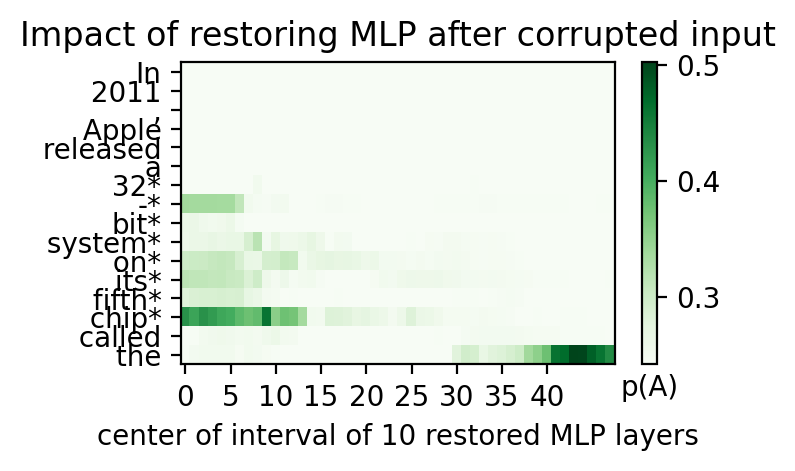

{0: {'mlp': {'scores': tensor([[0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418],
           [0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418,
            0.2418, 0.2418, 0.2418],
           [0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418, 0.2418

In [ ]:
plot_flows(mt, "In 2011, Apple released a 32-bit system on its fifth chip called the", plots=['mlp'], subject="32-bit system on its fifth chip")

In [ ]:
from tqdm import tqdm

for i, cf in tqdm(enumerate(counterfact)):
    rew = cf['requested_rewrite']
    text = rew['prompt'].replace("{}", rew['subject'])

## Does more uncertainty mean more token effect spread?

In [100]:
import numpy as np
import pandas as pd

In [102]:
# results_dict[0]['mlp']['high_score']
highs = []
tops = []
i = 0
for i in results_dict:
    top_count = 0
    if list(results_dict[i].keys()) == ["mlp"]:
        high_score = round(float(results_dict[i]['mlp']['high_score']), 4)
        top = high_score * 0.6
        for token_probs in results_dict[i]['mlp']['scores']:
            for prob in token_probs:
                if prob >= top:
                    top_count += 1
    i += 1
    highs.append(high_score)
    tops.append(top_count)
    # print("High Score: ", high_score, "Top Count: ", top_count)
    # if i > 2:
    #     break

df = pd.DataFrame({"high_score": highs, "top_score_count": tops})
df.sort_values(by="high_score")

,high_score,top_score_count
35,0.0192,93
47,0.0198,432
40,0.0335,432
44,0.0341,239
49,0.0418,336
25,0.0430,336
50,0.0463,45
38,0.0482,83
48,0.0489,145
46,0.0522,80


## Load StrategyQA Dataset

In [16]:
from dsets.knowns import KnownsDataset

In [17]:
knowns = KnownsDataset(DATA_DIR)

Loaded dataset with 1209 elements


In [18]:
import os
os.getcwd()

'/content/drive/MyDrive/rome'

In [19]:
with open('/content/drive/MyDrive/rome/data/strategyqa_train.json') as f:
    sqa = json.load(f)

In [20]:
sqa[0]


{'qid': 'b8677742616fef051f00',
 'term': 'Genghis Khan',
 'description': 'founder and first Great Khan of the Mongol Empire',
 'question': 'Are more people today related to Genghis Khan than Julius Caesar?',
 'answer': True,
 'facts': ['Julius Caesar had three children.',
  'Genghis Khan had sixteen children.',
  'Modern geneticists have determined that  out of every 200 men today has DNA that can be traced to Genghis Khan.'],
 'decomposition': ['How many kids did Julius Caesar have?',
  'How many kids did Genghis Khan have?',
  'Is #2 greater than #1?'],
 'evidence': [[[['Caesarion-2', 'Julia (daughter of Caesar)-1']],
   [['Alakhai Bekhi-1', 'Tolui-1'], 'no_evidence'],
   ['operation']],
  [[['Julius Caesar-75']], [['Genghis Khan-17']], ['operation']],
  [[['Gaius Julius Caesar-7']],
   [['Genghis Khan-15'], 'no_evidence'],
   ['no_evidence', 'operation']]]}

In [82]:
fact_str = "Facts: "

for f in sqa[0]['facts']:
    fact_str += f.replace("  ", " ") + " "

print("Question:", sqa[0]['question'])
print(fact_str)
print("Answer:", sqa[0]['answer'])

Question: Are more people today related to Genghis Khan than Julius Caesar?
Facts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan. 
Answer: True


In [84]:
sqa = sqa[1:]

In [154]:
from tqdm import tqdm
import numpy as np
device = 'cuda'
count = 0
for i, data in tqdm(enumerate(sqa)):
    example = """Question: Are more people today related to Genghis Khan than Julius Caesar?\nFacts: Julius Caesar had three children. Genghis Khan had sixteen children. Modern geneticists have determined that out of every 200 men today has DNA that can be traced to Genghis Khan.\nAnswer (True or False): True\n"""
    fact_str = "Facts: "
    ct_subject = ""
    for f in data['facts']:
        fact_str += f.replace("  ", " ") + " "
        ct_subject += f.replace("  ", " ") + " "
    fact_str = fact_str[:-1]
    ct_subject = ct_subject[:-1]
    # print(ct÷_subject)
    question = "Question: " + data['question']
    answer = "Answer (True or False):"
    correct_answer = str(data['answer'])
    prompt = example + question + "\n" + fact_str + "\n" + answer
    input_ids = mt.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt"
    ).input_ids.to(device)
    generated_outputs = mt.model.generate(
        input_ids,
        do_sample=True,
        early_stopping=True,
        max_length=200,
        num_return_sequences=1,
        output_scores=True,
        return_dict_in_generate=True,
        device=device,
        # repetition_penalty=1.2,
        # length_penalty=0.8,
        pad_token_id=mt.tokenizer.eos_token_id,
        temperature=0.05,
    )
    generated_text = mt.tokenizer.decode(generated_outputs.sequences[0])

    # only use id's that were generated
    # gen_sequences has shape [3, 15]
    gen_sequences = generated_outputs.sequences[:, input_ids.shape[-1] :]
    probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]
    # now we need to collect the probability of the generated token
    # we need to add a dummy dim in the end to make gather work
    gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
    # print(gen_probs)
    for j, sequence in enumerate(generated_outputs.sequences):
        generated_seq = sequence[len(sequence) - len(gen_probs[j]):len(sequence)]
        token_list = []
        for token in generated_seq:
            token_list.append(mt.tokenizer.decode(token))
        generated_text = mt.tokenizer.decode(generated_seq)
        first_token = mt.tokenizer.decode(generated_seq[0]).replace(' ', '')
    
    token_probs = []
    for token, prob in zip(generated_seq, gen_probs[0]):
        text = mt.tokenizer.decode(token)
        prob = str(np.array(prob.cpu()))
        token_probs.append((text, prob))

    # print(correct_answer)
    # print(first_token)
    try:
        if correct_answer.lower() in first_token.lower():
            sqa[i]["first_generated_token"] = first_token
            sqa[i]["gpt2_main_completion"] = generated_text
            sqa[i]["ct_prompt"] = prompt
            sqa[i]["ct_subject"] = ct_subject
            sqa[i]["good_gpt2_prompt"] = True
            sqa[i]["token_probs"] = token_probs
            count += 1
        else:
            sqa[i]["first_generated_token"] = first_token
            sqa[i]["gpt2_main_completion"] = generated_text
            sqa[i]["ct_prompt"] = prompt
            sqa[i]["ct_subject"] = ct_subject
            sqa[i]["good_gpt2_prompt"] = False
            sqa[i]["token_probs"] = token_probs
    except:
        pass

print("\n\n Number of prompts that created good completions: " + str(count))

391it [15:50,  2.16s/it]Input length of input_ids is 211, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
556it [22:29,  2.20s/it]Input length of input_ids is 205, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
864it [34:53,  2.77s/it]Input length of input_ids is 216, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
1438it [58:18,  2.09s/it]Input length of input_ids is 211, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
2157it [1:27:39,  2.45s/it]Input length of input_ids is 201, but ``max_length`` is set to 200. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``



 Number of prompts that created good completions: 1070


In [155]:
good_count = 0
bad_count = 0
good_sqa = {}
bad_sqa = {}
for i, data in tqdm(enumerate(sqa[1:])):
    try:
        if data["good_gpt2_prompt"] == True:
            good_sqa[good_count] = data
            good_count += 1
        else:
            bad_sqa[bad_count] = data
            bad_count += 1
    except:
        pass

print("\nGood counts: " + str(good_count))
print("\nBad counts: " + str(bad_count))

2288it [00:00, 933699.90it/s]


Good counts: 1070

Bad counts: 1218


In [156]:
good_sqa_filename = "/content/drive/MyDrive/rome/data/good_sqa_gpt2.json"
with open(good_sqa_filename, "w") as f:
    json.dump(good_sqa, f)

bad_sqa_filename = "/content/drive/MyDrive/rome/data/bad_sqa_gpt2.json"
with open(bad_sqa_filename, "w") as f:
    json.dump(bad_sqa, f)


In [157]:
from google.colab import files
files.download(good_sqa_filename)
files.download(bad_sqa_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>